# Анализ результатов А/А/В-эксперимента

**Содержание**

[Описание проекта](#description)
1. [Общая информация](#start)
2. [Подготовка данных](#preprocessing)
3. [Изучение и проверка данных](#analysis)   
    3.1. [Сколько всего событий в логе?](#1)     
    3.2. [Сколько всего пользователей в логе?](#2)    
    3.3. [Сколько в среднем событий приходится на пользователя?](#3)    
    3.4. [Определение временного периода](#4)  
    3.5. [Проверка наличия пользователей во всех экспериментальных группах](#5)
4. [Воронка событий](#funnel) 
5. [Результаты A/A/B-эксперимента](#experiment)
6. [Общий вывод](#conclusion)   

## Описание проекта <a id="description"></a>

Стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения:  
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  
После этого исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.   

**План работ**

**Шаг 1. Открыть файл с данными и изучить общую информацию**  
Путь к файлу: /datasets/logs_exp.csv.

**Шаг 2. Подготовить данные**  
* Заменить названия столбцов на удобные;
* Проверить пропуски и типы данных. Откорректировать, если нужно;
* Добавить столбец даты и времени, а также отдельный столбец дат;

**Шаг 3. Изучить и проверить данные**  
* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период мы располагаем? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
* Много ли событий и пользователей потеряли, отбросив старые данные?
* Проверить, что есть пользователи из всех трёх экспериментальных групп.

**Шаг 4. Изучить воронку событий**  
* Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.
* Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.
* Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
* На каком шаге теряется больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?

**Шаг 5. Изучить результаты эксперимента**  
* Сколько пользователей в каждой экспериментальной группе?
* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверить, находят ли статистические критерии разницу между выборками 246 и 247.
* Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
* Какой уровень значимости был выбран при проверке статистических гипотез выше? Посчитать, сколько проверок статистических гипотез сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? При желании изменить его проделать предыдущие пункты и проверить выводы.

**Описание данных**  
Каждая запись в логе — это действие пользователя, или событие.
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## 1. Общая информация <a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
sns.set_style("dark") 

Загрузим лог и рассмотрим общую информацию о таблице.

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Вывод
В таблице отсутствуют пропуски и типы данных соответствуют содержимому.
План подготовки данных для анализа:
* заменить названия столбцов на удобные,
* проверить на наличие дубликатов,
* добавить столбец даты и времени,
* добавить столбец даты.

## 2. Подготовка данных <a id="preprocessing"></a>

Переименуем столбцы.

In [4]:
df = df.rename(columns={
    "EventName": "event_name", 
    "DeviceIDHash": "uid",  
    "EventTimestamp": "event_ts",  
    "ExpId": "experiment_id"
})
df.head()

,event_name,uid,event_ts,experiment_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим, есть ли дубликаты в логе.

In [5]:
df.duplicated().sum()

413

In [6]:
df[df.duplicated()].head()

,event_name,uid,event_ts,experiment_id
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248


Один и тот же пользователь совершает одновременно сразу несколько одинаковых событий. Стоит сообщить команде, возможно здесь нужна обработка одновременных событий. Удалим дубликаты.

In [7]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
event_name       243713 non-null object
uid              243713 non-null int64
event_ts         243713 non-null int64
experiment_id    243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


Создадим столбец даты и времени и отдельный столбец даты.

In [8]:
df['datetime'] = pd.to_datetime(df['event_ts'], unit='s')
df['date'] = df['datetime'].dt.date
df.head()

,event_name,uid,event_ts,experiment_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Вывод
* Переименовали столбцы.
* Удалили 413 дубликатов.
* Создали столбцы `datetime` и `date`.

## 3. Изучение и проверка данных <a id="analysis"></a>

### 3.1. Сколько всего событий в логе? <a id="1"></a>

In [9]:
events_count = len(df)
print('Всего событий:', events_count)
print('Уникальных событий:', len(df['event_name'].unique()), df['event_name'].unique().tolist())

Всего событий: 243713
Уникальных событий: 5 ['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']


### 3.2. Сколько всего пользователей в логе? <a id="2"></a>

In [10]:
users_count = len(df['uid'].unique())
print('Всего пользователей:', users_count)

Всего пользователей: 7551


### 3.3. Сколько в среднем событий приходится на пользователя? <a id="3"></a>

In [11]:
print('Среднее количество событий на пользователя: {:.0f}'.format(len(df) / len(df['uid'].unique())))

Среднее количество событий на пользователя: 32


### 3.4. Определение временного периода <a id="4"></a>

Найдем минимальную и максимальную дату.

In [12]:
df['datetime'].min()

Timestamp('2019-07-25 04:43:36')

In [13]:
df['datetime'].max()

Timestamp('2019-08-07 21:15:17')

Построим гистограмму по дате и времени.

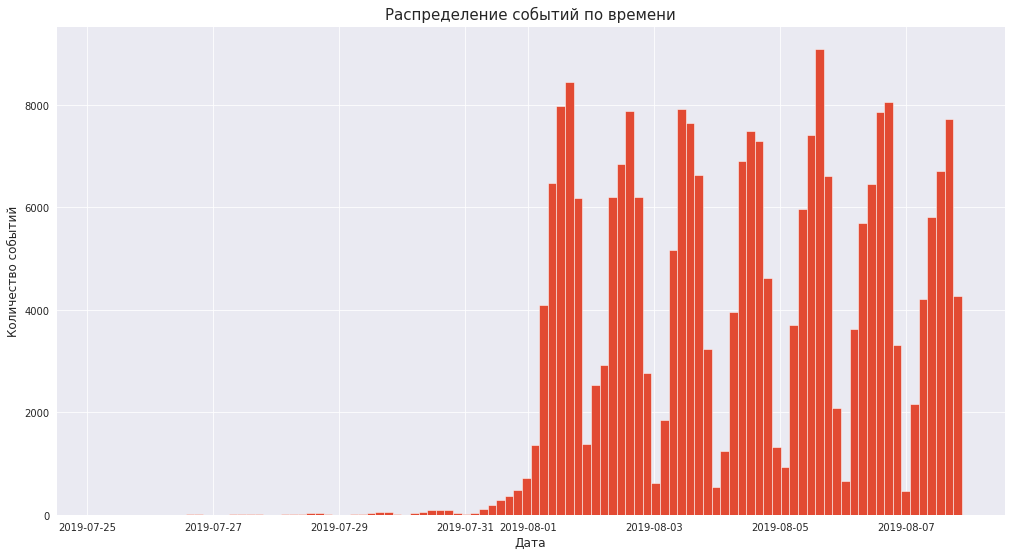

In [14]:
plt.figure(figsize=(17, 9))
df['datetime'].hist(bins=100)

plt.title('Распределение событий по времени', fontsize = 15)
plt.ylabel('Количество событий', fontsize = 12)
plt.xlabel('Дата', fontsize = 12)
plt.show()

В логах присутствуют неполные данные.  С 01.08.2019 данные полные. Мы располагаем данными за период с 01.08.2019 00:00:00 по 07.08.2019 21:15:17. Отбросим старые данные.

In [15]:
df = df[df['datetime'] >= "2019-08-01"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
event_name       240887 non-null object
uid              240887 non-null int64
event_ts         240887 non-null int64
experiment_id    240887 non-null int64
datetime         240887 non-null datetime64[ns]
date             240887 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


In [16]:
print('Осталось событий всего:', len(df))
print('Всего событий потеряли:', events_count - len(df), 'или', '{:.1%}'.format((events_count - len(df)) / events_count))

Осталось событий всего: 240887
Всего событий потеряли: 2826 или 1.2%


In [17]:
print('Осталось пользователей всего:', len(df['uid'].unique()))
print('Всего пользователей потеряли:', 
      users_count - len(df['uid'].unique()), 
      'или', 
      '{:.1%}'.format((users_count - len(df['uid'].unique())) / users_count))

Осталось пользователей всего: 7534
Всего пользователей потеряли: 17 или 0.2%


### 3.5. Проверка наличия пользователей во всех экспериментальных группах <a id="5"></a>

In [18]:
df.groupby('experiment_id')['uid'].nunique().reset_index()

,experiment_id,uid
0,246,2484
1,247,2513
2,248,2537


### Вывод
Мы располагаем данными за период с 01.08.2019 00:00:00 по 07.08.2019 21:15:17. В логах за этот период всего 7534 пользователя и 240887 событий. На одного пользователя приходится в среднем по 32 события. Для каждой экспериментальной группы есть пользователи.

## 4. Воронка событий <a id="funnel"></a>

Рассмотрим, как часто встречаются события.

In [19]:
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [20]:
df['event_name'].value_counts(normalize=True)

MainScreenAppear           0.487067
OffersScreenAppear         0.192343
CartScreenAppear           0.175613
PaymentScreenSuccessful    0.140805
Tutorial                   0.004172
Name: event_name, dtype: float64

Самое частое событие - **MainScreenAppear**.

Посчитаем, сколько пользователей совершили каждое из событий.

In [21]:
users_count_by_event = df.groupby('event_name')['uid'].nunique().sort_values(ascending=False).reset_index()
users_count_by_event.columns = ['event_name', 'users_count']
users_count_by_event

,event_name,users_count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [22]:
users_count_by_event['users_ratio'] = users_count_by_event['users_count'] / len(df['uid'].unique())
users_count_by_event

,event_name,users_count,users_ratio
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Возможно события происходят в следующем порядке: *MainScreenAppear*, *OffersScreenAppear*, *CartScreenAppear*, *PaymentScreenSuccessful*. При этом между *MainScreenAppear* и *OffersScreenAppear* есть другие события, которые не логируются, например, ими могут быть - открытие каталога или открытие страницы товара. Событие *Tutorial*  не относится к покупке и может происходить в разных последовательностях, в зависимости от возможностей приложения. Это событие совершают 11% пользователей. Т.к. оно не является обязательным действием, при расчете воронки не будем учитывать событие *Tutorial*.

In [23]:
funnel = users_count_by_event.query('event_name != "Tutorial"')[['event_name', 'users_count']]

OffersScreenAppear_ratio = users_count_by_event.loc[1,'users_count'] / users_count_by_event.loc[0,'users_count']
CartScreenAppear_ratio = users_count_by_event.loc[2,'users_count'] / users_count_by_event.loc[1,'users_count']
PaymentScreenSuccessful_ratio = users_count_by_event.loc[3,'users_count'] / users_count_by_event.loc[2,'users_count']
funnel['conversion_to_the_next_step'] = [1, OffersScreenAppear_ratio, CartScreenAppear_ratio, PaymentScreenSuccessful_ratio]
funnel['total_conversion'] = [1, 
                              users_count_by_event.loc[1,'users_count'] / users_count_by_event.loc[0,'users_count'], 
                              users_count_by_event.loc[2,'users_count'] / users_count_by_event.loc[0,'users_count'], 
                              users_count_by_event.loc[3,'users_count'] / users_count_by_event.loc[0,'users_count']
                        ]
funnel

,event_name,users_count,conversion_to_the_next_step,total_conversion
0,MainScreenAppear,7419,1.000000,1.000000
1,OffersScreenAppear,4593,0.619086,0.619086
2,CartScreenAppear,3734,0.812976,0.503302
3,PaymentScreenSuccessful,3539,0.947777,0.477018


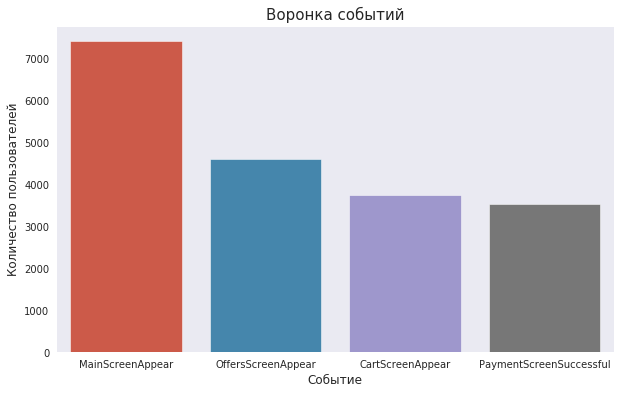

In [24]:
plt.figure(figsize=(10,6))
fig = sns.barplot(data = funnel, x='event_name', y='users_count')

plt.title('Воронка событий', fontsize = 15)
plt.ylabel('Количество пользователей', fontsize = 12)
plt.xlabel('Событие', fontsize = 12)
plt.show()

### Вывод
На первом шаге (переход от стартовой страницы к странице заказа) теряется больше всего пользователей - 38,1%. Это происходит потому, что во-первых, не все пользователи, открывают приложение, чтобы заказать товар, во-вторых, кто-то не находит подходящие товары, в-третьих, между открытием главной страницы и оформлением заказа пользователь совершает другие промежуточные шаги: открывает меню, страницы товара, переходит по ссылкам, эти события не представлены в логе. Необходимо провести анализ поведения пользователей перед оформлением заказа, чтобы понять, чтобы найти слабые места приложения.  
На втором шаге (переход от страницы заказа к странице оплаты) теряется 18,7% пользователей. На третьем шаге (переход к странице об успешно проведенной оплате) потеряли 5,3% пользователей. Доля пользователей, которая доходит от страницы заказа до успешной оплаты: 47,7%.  
Необходимо обратить внимание на страницу заказа. Все ли работает, отображается корректно на странице? Нет ли лишних с точки зрения пользователей полей для заполнения? Предложены ли удобные для пользователей способы доставки, оплаты? Возможно более детальное рассмотрение процесса оформления заказа, сможет подсказать пути для увеличения конверсии из оформления заказа в оплату.

## 5.  Результаты A/A/B-эксперимента <a id="experiment"></a>

Изучим результаты эксперимента. Рассмотрим количество пользователей в каждой группе.

In [25]:
users_count_by_experiment = df.groupby('experiment_id')['uid'].nunique().reset_index()
users_count_by_experiment = users_count_by_experiment.rename(columns={"uid": "users_count"})
users_count_by_experiment

,experiment_id,users_count
0,246,2484
1,247,2513
2,248,2537


Количество пользователей в различных группах различается не более, чем на 1%.

Проверим, что нет пересечений пользователей между группами 246 и 247.

In [26]:
len(df.query('experiment_id == 246').set_index('uid').join(
    df.query('experiment_id == 247').set_index('uid'), how='inner', lsuffix='_l', rsuffix='_r')
   )

0

Рассмотрим распределение пользователей в каждой группе по дням.

In [27]:
experiment_table = df.pivot_table(
    index = 'date', 
    columns = 'experiment_id', 
    values = 'uid', 
    aggfunc = 'nunique'
).reset_index()
experiment_table.columns = ['date', 'exp_246', 'exp_247', 'exp_248']
experiment_table

,date,exp_246,exp_247,exp_248
0,2019-08-01,1191,1282,1230
1,2019-08-02,1197,1221,1229
2,2019-08-03,1140,1176,1166
3,2019-08-04,1170,1169,1188
4,2019-08-05,1269,1263,1270
5,2019-08-06,1270,1320,1332
6,2019-08-07,1198,1212,1241


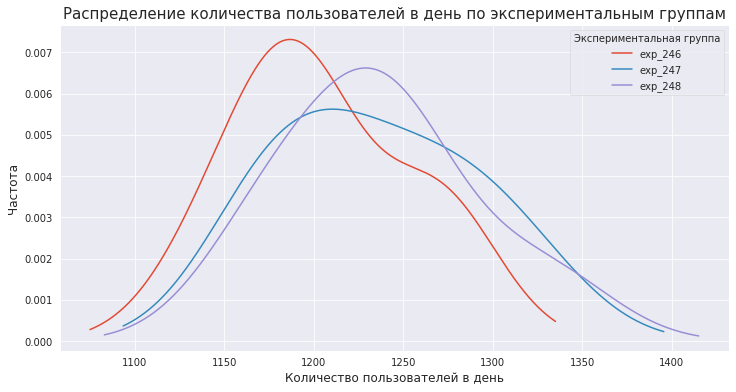

In [28]:
experiment_table.plot(figsize=(12,6), rot=0, legend=True, grid=True, kind='kde')
plt.title('Распределение количества пользователей в день по экспериментальным группам', fontsize = 15)
plt.ylabel('Частота', fontsize=12)
plt.xlabel('Количество пользователей в день', fontsize=12)
plt.legend(title = 'Экспериментальная группа')
plt.show()

Проверим распределения на нормальность с помощью критерия Шапиро-Уилка.
Нулевую гипотезу сформулируем следующим образом:  
**H₀ - выборка распределена нормально.**  
Альтернативная гипотеза будет звучать следующим образом:  
**H₁ - выборка распределена не нормально.**  

In [29]:
def test_shapiro(sample):
    alpha = .05

    results = st.shapiro(sample)
    p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: распределение не нормально")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

In [30]:
sample_246 = experiment_table['exp_246'].tolist()
sample_247 = experiment_table['exp_247'].tolist()
sample_248 = experiment_table['exp_248'].tolist()

In [31]:
test_shapiro(sample_246)

p-значение:  0.2786673605442047
Не получилось отвергнуть нулевую гипотезу, всё нормально


In [32]:
test_shapiro(sample_247)

p-значение:  0.708777129650116
Не получилось отвергнуть нулевую гипотезу, всё нормально


In [33]:
test_shapiro(sample_248)

p-значение:  0.7779155373573303
Не получилось отвергнуть нулевую гипотезу, всё нормально


Проверим, находят ли статистические критерии разницу между выборками 246 и 247, применим метод scipy.stats.ttest_ind (array1, array2, equal_var).
Нулевую гипотезу сформулируем следующим образом:  
**H₀ - среднее количество пользователей в день в выборке 246 равно среднему количеству пользователей в день в выборке 247.**  
Альтернативная гипотеза будет звучать следующим образом:  
**H₁ - среднее количество пользователей в день в выборке 246 не равно среднему количеству пользователей в день в выборке 247.** 

In [34]:
sample_246 = experiment_table['exp_246'].tolist()
sample_247 = experiment_table['exp_247'].tolist()

alpha = .05

results = st.ttest_ind(
    sample_246, 
    sample_247,
    equal_var = True
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.30899748048237163
Не получилось отвергнуть нулевую гипотезу


Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп, а также долю пользователей, совершивших эти события. 

In [35]:
funnel_by_experiments = df.pivot_table(
    index = 'event_name', columns = 'experiment_id', values = 'uid', aggfunc = 'nunique'
).reset_index()
funnel_by_experiments.columns = ['event_name', 'exp_246', 'exp_247', 'exp_248']
funnel_by_experiments = funnel_by_experiments.sort_values(by='exp_246', ascending=False).reset_index(drop=True)
funnel_by_experiments['conversion_246'] = funnel_by_experiments['exp_246'] / users_count_by_experiment.loc[0,'users_count'] 
funnel_by_experiments['conversion_247'] = funnel_by_experiments['exp_247'] / users_count_by_experiment.loc[1,'users_count']
funnel_by_experiments['conversion_248'] = funnel_by_experiments['exp_248'] / users_count_by_experiment.loc[2,'users_count']
funnel_by_experiments

,event_name,exp_246,exp_247,exp_248,conversion_246,conversion_247,conversion_248
0,MainScreenAppear,2450,2476,2493,0.986312,0.985277,0.982657
1,OffersScreenAppear,1542,1520,1531,0.620773,0.604855,0.603469
2,CartScreenAppear,1266,1238,1230,0.509662,0.492638,0.484825
3,PaymentScreenSuccessful,1200,1158,1181,0.483092,0.460804,0.465510
4,Tutorial,278,283,279,0.111916,0.112614,0.109972


Проверим, будет ли отличие между группами статистически достоверным. Так как распределение статистики нормальное, вызовем метод cdf().  
Нулевую гипотезу сформулируем следующим образом:  
**H₀ - Пропорции выборок равны.**  
Альтернативная гипотеза будет звучать следующим образом:  
**H₁ - Пропорции выборок не равны.**

In [36]:
def test_equality_of_shares(n1, n2, p1, p2):
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([p1, p2])
    trials = np.array([n1, n2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    # считаем статистику в ст.отклонениях стандартного нормального распределения

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

In [37]:
users_count_by_experiment

,experiment_id,users_count
0,246,2484
1,247,2513
2,248,2537


In [38]:
funnel_by_experiments

,event_name,exp_246,exp_247,exp_248,conversion_246,conversion_247,conversion_248
0,MainScreenAppear,2450,2476,2493,0.986312,0.985277,0.982657
1,OffersScreenAppear,1542,1520,1531,0.620773,0.604855,0.603469
2,CartScreenAppear,1266,1238,1230,0.509662,0.492638,0.484825
3,PaymentScreenSuccessful,1200,1158,1181,0.483092,0.460804,0.465510
4,Tutorial,278,283,279,0.111916,0.112614,0.109972


In [39]:
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[1,'users_count'], funnel_by_experiments.loc[0,'exp_246'], funnel_by_experiments.loc[0,'exp_247'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[1,'users_count'], funnel_by_experiments.loc[1,'exp_246'], funnel_by_experiments.loc[1,'exp_247'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[1,'users_count'], funnel_by_experiments.loc[2,'exp_246'], funnel_by_experiments.loc[2,'exp_247'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[1,'users_count'], funnel_by_experiments.loc[3,'exp_246'], funnel_by_experiments.loc[3,'exp_247'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[1,'users_count'], funnel_by_experiments.loc[4,'exp_246'], funnel_by_experiments.loc[4,'exp_247'])

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты А/А теста:
* количество пользователей в группах 246 и 247 различается не более, чем на 1%; 
* для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* различие конверсий по группам не имеет статистической значимости;
* попавший в одну из групп посетитель остаётся в этой группе до конца теста. 

Можно сказать, что разбиение на группы работает корректно.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 

Сравнение групп 246 и 248.

In [40]:
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[0,'exp_246'], funnel_by_experiments.loc[0,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[1,'exp_246'], funnel_by_experiments.loc[1,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[2,'exp_246'], funnel_by_experiments.loc[2,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[3,'exp_246'], funnel_by_experiments.loc[3,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[0,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[4,'exp_246'], funnel_by_experiments.loc[4,'exp_248'])

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение групп 247 и 248.

In [41]:
test_equality_of_shares(users_count_by_experiment.loc[1,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[0,'exp_247'], funnel_by_experiments.loc[0,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[1,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[1,'exp_247'], funnel_by_experiments.loc[1,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[1,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[2,'exp_247'], funnel_by_experiments.loc[2,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[1,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[3,'exp_247'], funnel_by_experiments.loc[3,'exp_248'])
test_equality_of_shares(users_count_by_experiment.loc[1,'users_count'], users_count_by_experiment.loc[2,'users_count'], funnel_by_experiments.loc[4,'exp_247'], funnel_by_experiments.loc[4,'exp_248'])

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение объединенной группы 246+247 и 248.

In [42]:
test_equality_of_shares(
    users_count_by_experiment.loc[0,'users_count']+users_count_by_experiment.loc[1,'users_count'], 
    users_count_by_experiment.loc[2,'users_count'], 
    funnel_by_experiments.loc[0,'exp_246']+funnel_by_experiments.loc[0,'exp_247'], 
    funnel_by_experiments.loc[0,'exp_248']
)
test_equality_of_shares(
    users_count_by_experiment.loc[0,'users_count']+users_count_by_experiment.loc[1,'users_count'], 
    users_count_by_experiment.loc[2,'users_count'], 
    funnel_by_experiments.loc[1,'exp_246']+funnel_by_experiments.loc[1,'exp_247'], 
    funnel_by_experiments.loc[1,'exp_248']
)
test_equality_of_shares(
    users_count_by_experiment.loc[0,'users_count']+users_count_by_experiment.loc[1,'users_count'], 
    users_count_by_experiment.loc[2,'users_count'], 
    funnel_by_experiments.loc[2,'exp_246']+funnel_by_experiments.loc[2,'exp_247'], 
    funnel_by_experiments.loc[2,'exp_248']
)
test_equality_of_shares(
    users_count_by_experiment.loc[0,'users_count']+users_count_by_experiment.loc[1,'users_count'], 
    users_count_by_experiment.loc[2,'users_count'], 
    funnel_by_experiments.loc[3,'exp_246']+funnel_by_experiments.loc[3,'exp_247'], 
    funnel_by_experiments.loc[3,'exp_248']
)
test_equality_of_shares(
    users_count_by_experiment.loc[0,'users_count']+users_count_by_experiment.loc[1,'users_count'], 
    users_count_by_experiment.loc[2,'users_count'], 
    funnel_by_experiments.loc[4,'exp_246']+funnel_by_experiments.loc[4,'exp_247'], 
    funnel_by_experiments.loc[4,'exp_248']
)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При проверках гипотез был выбран уровень значимости 0,05. Даже при изменении на 0,01 результаты не изменятся: р-значение намного больше уровня значимости. Нет различий между конверсиями в экспериментальных группах.

### Вывод
Результаты A/A/B-эксперимента:
* две контрольные группы 246 и 247 статистически равны, можно быть увереными в точности проведенного тестирования,
* между долями пользователей, совершивших события, в контрольных группах нет статистически значимых различий,
* между долями пользователей группы с измененными шрифтами и долями пользователей из контрольных групп нет статистически значимых различий,
* нет различий между долями пользователей группы с измененными шрифтами и объединенной контрольной группы.

Можно сделать вывод, что новые шрифты в приложении не повлияли на конверсии пользователей из оформления заказа на страницу оплату и из страницы оплаты к успешной оплате. Можно поменять шрифты в приложении, поведение пользователей не изменится.

### 6.  Общий вывод <a id="conclusion"></a>

Цель данного исследования - выяснить, изменится ли поведение пользователей после изменения шрифтов в приложении. В распоряжении лог событий за период с 01.08.2019 00:00:00 по 07.08.2019 21:15:17, в котором все пользователи в результате A/A/B-эксперимента разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.
Изучили воронку продаж, а также проверили гипотезы о равенстве конверсий между экспериментальными группами.

Выяснили, что при покупке продуктов в мобильном приложении до успешной оплаты доходят 47,7% пользователей. На первом шаге (переход от стартовой страницы к странице заказа) теряется больше всего пользователей - 38,1%. Это происходит потому, что во-первых, не все пользователи, открывают приложение, чтобы заказать товар, во-вторых, кто-то не находит подходящие товары, в-третьих, между открытием главной страницы и оформлением заказа пользователь совершает другие промежуточные шаги: открывает меню, страницы товара, переходит по ссылкам, эти события не представлены в логе. Необходимо провести анализ поведения пользователей перед оформлением заказа, чтобы найти слабые места приложения.
На втором шаге (переход от страницы заказа к странице оплаты) теряется 18,7% пользователей. На третьем шаге (переход к странице об успешно проведенной оплате) потеряли 5,3% пользователей.   
Необходимо обратить внимание на страницу заказа. Все ли работает, отображается корректно на странице? Нет ли лишних, с точки зрения пользователей, полей для заполнения? Предложены ли удобные для пользователей способы доставки, оплаты? Возможно более детальное рассмотрение процесса оформления заказа, сможет подсказать пути для увеличения конверсии из оформления заказа в оплату.

При анализе A/A/B-эксперимента были изучены две контрольные группы: они оказались равны, что указывает на точность проведенного тестирования. Выдвинули гипотезы: нулевая гипотеза - доли пользователей, совершивших событие, разных экспериментальных групп равны, альтернативная - доли пользователей, совершивших событие, разных экспериментальных групп не равны. Был выбран уровень значимости 0,05. Для проверки гипотез использовали z-критерий Фишера. Было проведено 15 проверок гипотез: сравнили доли пользователей 5 событий экспериментальной группы с каждной контрольной группой и с объединенной контрольной группой. Результатами всех проверок стало отсутствие статистически значимых различий между долями пользователей во всех группах.
 
Можно сделать вывод, что изменение шрифтов в приложении не повлияет на поведение пользователей, конверсии пользователей не изменятся.